<a href="https://colab.research.google.com/github/abdinegara783/BDC/blob/main/Image_Preprocessing_Rotating_(2)_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparing Dependencies**

In [1]:
 !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


In [32]:
import io
import os
import cv2
import math
import torch
import random
import shutil
import re
import requests
import statistics
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from PIL import Image, ImageOps
from skimage.filters import threshold_local
from google.colab.patches import cv2_imshow
from transformers import YolosFeatureExtractor, YolosForObjectDetection

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# **Define Function**

## **Function for Preprocess Images**

In [10]:
def convert_to_grayscale(image):
    '''
    Converts an image to grayscale if its dimensions are (height, width, 3).
    If the image is already grayscale, it returns the image as it is.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        numpy.ndarray: The grayscale image.
    '''
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray
    else:
        return image

In [11]:
def resize_image(image, max_size=400):
    '''
    Resizes an image while maintaining its aspect ratio.

    Parameters:
        image (numpy.ndarray): The input image.
        max_size (int): The maximum size for either width or height of the resized image. Default is 300.

    Returns:
        numpy.ndarray: The resized image.
    '''
    # Calculate the width and height of the image
    height, width = image.shape[:2]

    # Determine the resize scale based on the smallest dimension
    scale = min(max_size / float(width), max_size / float(height))

    # Calculate the new dimensions based on the scale
    new_width = int(scale * width)
    new_height = int(scale * height)

    # Perform the resize
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image

In [12]:
def contrast_stretching(image):
    """
    Perform contrast stretching on the input image.

    Parameters:
        image (numpy.ndarray): Input RGB image.

    Returns:
        numpy.ndarray: Contrast-stretched image.
    """
    # Convert image to float
    image = image.astype(np.float32)

    # Normalize image to the range [0, 1]
    image_normalized = image / 255.0

    # Calculate minimum and maximum pixel values in each channel
    min_vals = np.min(image_normalized, axis=(0, 1))
    max_vals = np.max(image_normalized, axis=(0, 1))

    # Calculate the range of each channel
    ranges = max_vals - min_vals

    # Perform contrast stretching on each channel
    stretched_image = (image_normalized - min_vals) / ranges

    # Clip values outside the range [0, 1]
    stretched_image = np.clip(stretched_image, 0, 1)

    # Convert image back to the original data type
    stretched_image = (stretched_image * 255).astype(np.uint8)
    return stretched_image

In [13]:
def detect_lines(image, threshold1, threshold2, min_line_length, max_line_gap):
    """
    Detects lines in an image using probabilistic Hough line transform.

    Args:
        image (numpy.ndarray): Grayscale image.
        threshold1 (int): First threshold for the Hough line transform.
        threshold2 (int): Second threshold for the Hough line transform.
        min_line_length (int): Minimum length of a line to be detected.
        max_line_gap (int): Maximum allowed gap between line segments to be connected into a single line.

    Returns:
        numpy.ndarray: Array representing the detected lines.
    """
    # Detects lines with Hough line transform
    lines = cv2.HoughLinesP(image, 1, np.pi/180, threshold=threshold1, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

In [14]:
def detect_edges(image):
    """
    Detects edges in an image using the Canny edge detection method.

    Args:
        image (numpy.ndarray): Grayscale image.

    Returns:
        numpy.ndarray: Array representing the detected edges.
    """
    # Detects edges using Canny
    edges = cv2.Canny(image, 30, 150)
    return edges

In [15]:
def rotated_90(image):
    """
    Rotates the input image by 90 degrees clockwise.

    Args:
        image: PIL Image or NumPy array representing the image.

    Returns:
        NumPy array: Rotated and resized image as a NumPy array.
    """
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Rotate the image by 90 degrees clockwise
    rotated_image = np.rot90(image_array)

    # Get the new width and height from the rotated image shape
    new_height, new_width, _ = rotated_image.shape

    # Create a PIL Image from the rotated NumPy array
    rotated_pil_image = Image.fromarray(rotated_image)

    # Resize the image
    resized_image = rotated_pil_image.resize((new_width, new_height))

    # Convert the image back to a NumPy array
    resized_image = np.array(resized_image)
    return resized_image

In [16]:
def transform_image(image, angle):
    """
    Performs a perspective transformation on an image based on a specified angle.
    The y position of each pixel remains unchanged, while only the x position changes.

    Args:
        image (numpy.ndarray): Input image.
        angle (float): Angle in degrees for the perspective transformation.

    Returns:
        numpy.ndarray: Transformed image.
    """
    # Convert angle to radians
    angle_radians = np.deg2rad(angle)

    # Calculate the shift amount based on the angle
    height = image.shape[0]
    width = image.shape[1]
    shift = int(width * np.tan(angle_radians))

    # Define the input and output quadrilateral coordinates
    src_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    dst_pts = np.float32([[0, shift], [width, 0], [width, height], [0, height + shift]])

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Apply the perspective transform to the image
    warped_image = cv2.warpPerspective(image, matrix, (width, image.shape[0]))
    return warped_image

In [17]:
def add_black_border(image, border_size):
    """
    Adds a black border to an input image.

    Args:
        image (numpy.ndarray): Input image.
        border_size (int): Size of the border to be added.

    Returns:
        numpy.ndarray: Image with the black border added.
    """
    # Get the dimensions of the input image
    height, width = image.shape[:2]

    # Calculate the new dimensions with the added border
    new_height = height + 2 * border_size
    new_width = width + 2 * border_size

    # Create a black image with the new dimensions
    bordered_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Calculate the coordinates for placing the input image in the center of the bordered image
    x = border_size
    y = border_size

    # Copy the input image to the center of the bordered image
    bordered_image[y:y+height, x:x+width] = image
    return bordered_image

In [18]:
def crop_black(image):
    """
    Crops an image to remove any black borders or areas.

    Args:
        image (np.ndarray): Input image as a NumPy array.

    Returns:
        PIL.Image.Image: Cropped image.
    """
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image)

    # Find the top, bottom, left, and right boundaries
    img_array = np.array(image)
    non_black_rows = np.where(np.any(img_array != 0, axis=1))[0]
    non_black_cols = np.where(np.any(img_array != 0, axis=0))[0]

    if len(non_black_rows) == 0 or len(non_black_cols) == 0:
        # Handle case when no non-black rows or columns found
        return image

    top = non_black_rows[0]
    bottom = non_black_rows[-1] + 1
    left = non_black_cols[0]
    right = non_black_cols[-1] + 1

    # Crop the image using the boundaries found
    cropped_img = image.crop((left, top, right, bottom))

    # Return the cropped image
    return cropped_img

In [19]:
def average_middle_value(data, bins=20):
    """
    Function to create a histogram and calculate the average middle value of bins with the maximum frequency.

    Parameters:
    - data: A list or array of data points.
    - bins: Number of bins for the histogram. Default is 20.

    Returns:
    - average_middle_value: The average middle value of bins with the maximum frequency.
    """
    # Create a histogram without visualization
    frequencies, bins = np.histogram(data, bins=bins)

    # Find the middle values of the bins with the maximum frequency
    max_frequency = np.max(frequencies)
    max_frequency_bins = bins[np.where(frequencies == max_frequency)]
    bin_width = bins[1] - bins[0]
    middle_values = max_frequency_bins + bin_width / 2

    # Calculate the average middle value if there are multiple bins with the maximum frequency
    average_middle_value = np.mean(middle_values)
    return average_middle_value

## **Function for Visualization**

In [20]:
def create_histogram(data, bins=20):
    """
    Creates a histogram plot for the given data and displays the histogram plot.

    Args:
        data (array-like): Input data.
        bins (int): Number of bins for the histogram.

    Returns:
        None
    """
    # Create a figure with the specified size
    plt.figure(figsize=(5, 4))

    # Create a histogram with appealing color and edge properties
    plt.hist(data, bins=bins, color='orange', edgecolor='black', alpha=1, linewidth=1.5)

    # Set title and axis labels for the histogram
    plt.title('Histogram')
    plt.xlabel('Data')
    plt.ylabel('Frequency')

    # Display the grid
    plt.grid(True)

    # Display the histogram plot
    plt.show()

# **Preparing Sample Image**

In [4]:
import zipfile

zip_file_path = '/content/Real-ESRGAN_result.zip'
extract_path = '/content/DataTest'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified extract path
    zip_ref.extractall(extract_path)

print("File successfully extracted.")


File successfully extracted.


In [ ]:
# Specify the folder that contains the images
#folder_path = "/content/drive/MyDrive/Data Train for BDC 2023 - Rename/"

In [ ]:
# Get a list of all files in the folder
#files = os.listdir(folder_path)

In [ ]:
# Randomly select a file from the list of files
#random_file = random.choice(files)
random_file = "B1289QQ__.png"

In [ ]:
# Combine the folder path with the randomly selected file name
image_path = os.path.join(folder_path, random_file)

In [ ]:
# Read the image
image = cv2.imread('/content/DataTest/DataTest63_out.png')

In [ ]:
# Print the name of the file to be preprocessed
#print(random_file)

# **Sample Image**

-177.88647206520898 



/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


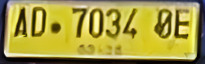

1
-175.85388976261373 



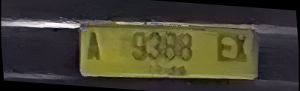

2
-0.9975978874990119 



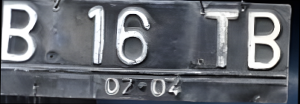

3
-178.56790381583534 



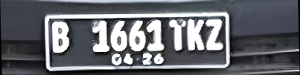

4
-151.3020050692832 



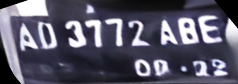

5
-2.5901859677828867 



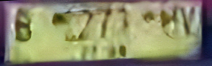

6
-23.096432129740293 



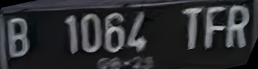

7
-2.0563543924956633 



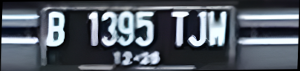

8
-10.831272223595676 



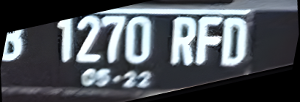

9
-0.08327869064665094 



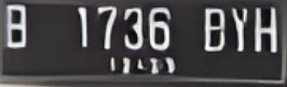

10
-0.18191543221634277 



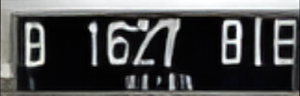

11
-179.94997312963466 



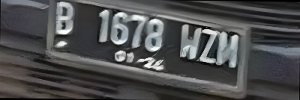

12
-12.215419010093939 



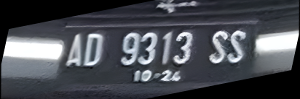

13
-178.45118101735474 



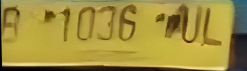

14
-6.862429131013357 



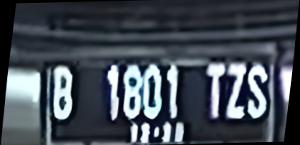

15
-1.4699780652438221 



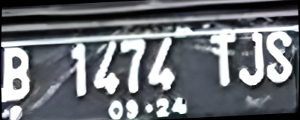

16
-30.887365490292417 



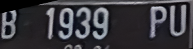

17
-179.9749866979884 



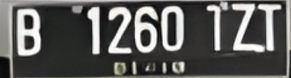

18
-1.3716087031911854 



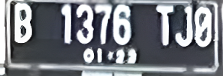

19
-178.56790381583534 



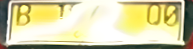

20
-25.15531653854613 



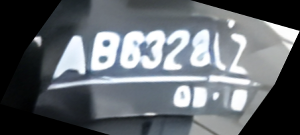

21
-0.323093076318159 



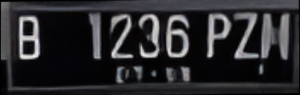

22
-1.1813144292933373 



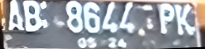

23
-174.61017506230434 



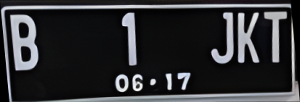

24


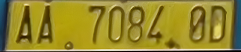

25
-6.15587621554333 



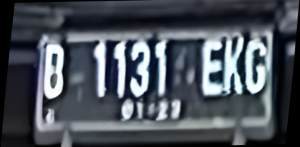

26
-176.76171760039375 



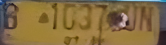

27
-179.91139834972864 



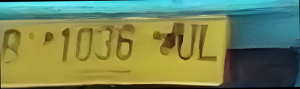

28
-0.08425843854404036 



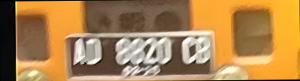

29
-17.227605093813864 



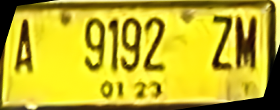

30
-179.91861400429252 



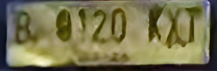

31
-179.95225352812486 



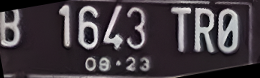

32
-144.24344205476626 



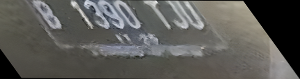

33
-137.57590181197628 



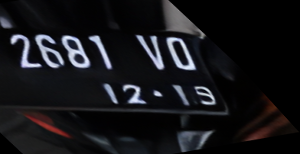

34
-3.2462981888528333 



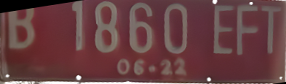

35
-169.39496246988085 



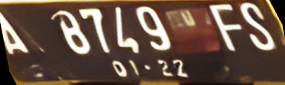

36
-179.94594739385337 



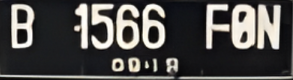

37
-1.265631097151342 



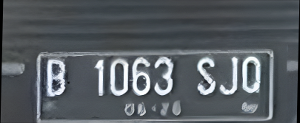

38
-1.8984347280552356 



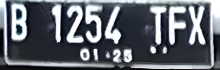

39
-1.3450938079597563 



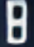

40
-170.72360178896525 



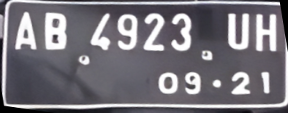

41
-9.475032008064048 



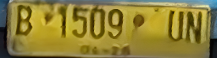

42
-179.26380146509837 



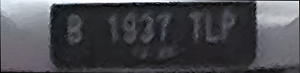

43
-14.84351397813252 



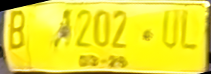

44
-8.248164802868914 



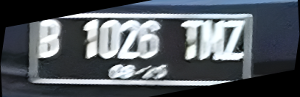

45
-3.771438946478824 



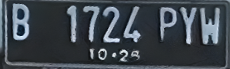

46
-1.2523705843941428 



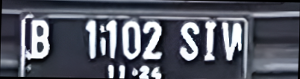

47
-179.2218849417672 



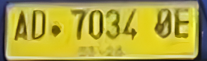

48
-0.5388372782053352 



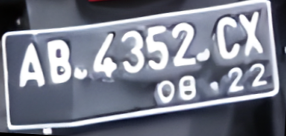

49
-0.650013128939321 



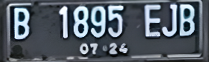

50
-143.59728978117028 



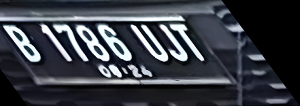

51


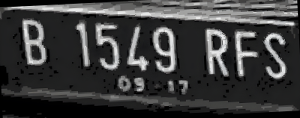

52
-7.278821550546681 



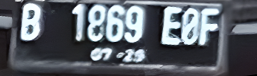

53
-175.53284093861072 



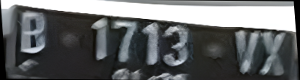

54
-13.170096653589397 



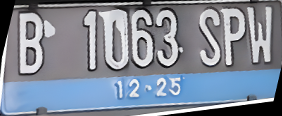

55
-179.41256176923585 



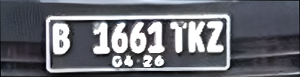

56
-1.6778814113993405 



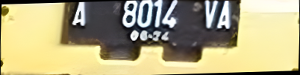

57
-2.862405226111747 



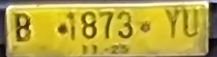

58
-3.13694584864092 



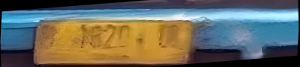

59
-2.719870045326388 



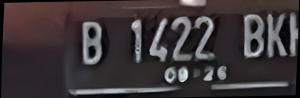

60
-155.3947589600265 



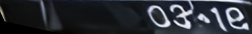

61
-1.0358411255068205 



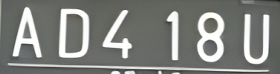

62
-179.34633055396336 



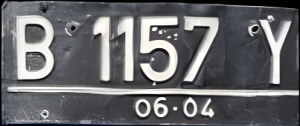

63
-1.1736035440682429 



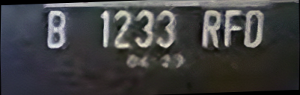

64
-179.95659411473332 



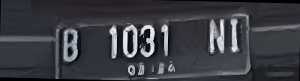

65
-174.51423793532365 



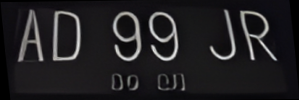

66
-3.19459927836391 



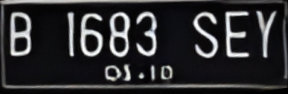

67
-0.8838519531592368 



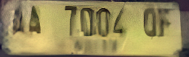

68
-0.05115693239982022 



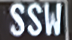

69
-178.56790381583534 



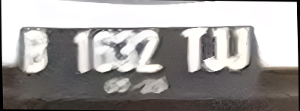

70
-179.28019203494918 



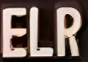

71
-0.5707352333560891 



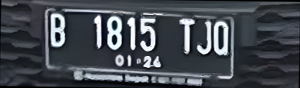

72
-3.2469952079973297 



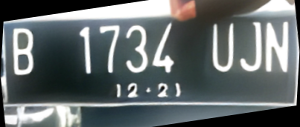

73
-2.713191826181088 



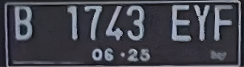

74
-174.78407066316666 



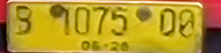

75
-177.17728565425125 



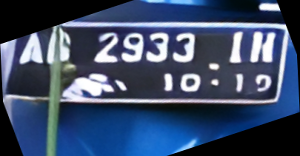

76
-2.549382786020388 



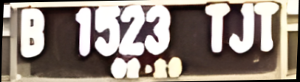

77
-172.69516225795175 



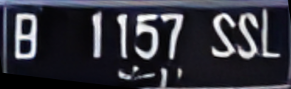

78
-175.53284093861072 



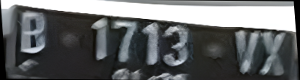

79
-0.758198817374307 



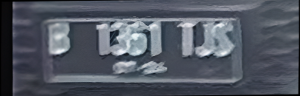

80
-177.09476949786946 



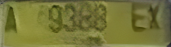

81
-6.446020838190279 



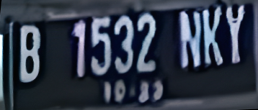

82
-179.61469604489324 



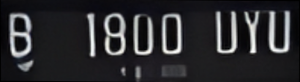

83
-0.312459534685118 



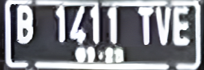

84
-179.74722614210845 



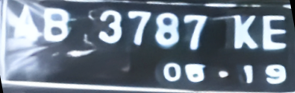

85
-0.017871211250678698 



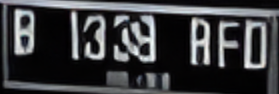

86
-178.73556873216938 



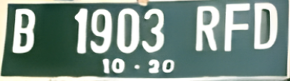

87
-6.055533236360077 



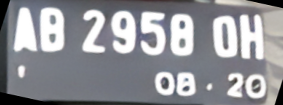

88
-179.84578812938565 



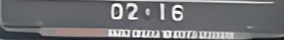

89
-176.70808176845628 



90
-0.3373983955431328 



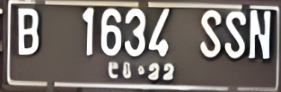

91
-6.637992405788154 



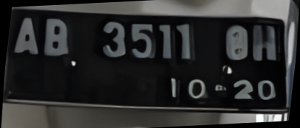

92
-5.449967485173147 



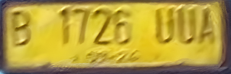

93
-175.63814061944709 



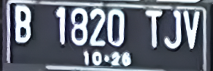

94
-2.2215299112796885 



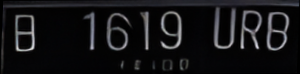

95
-178.15972503000512 



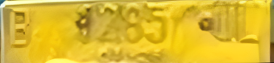

96
-2.5046502485057403 



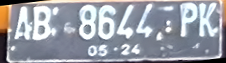

97
-1.393043526802316 



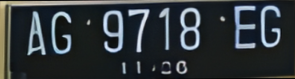

98
-9.475032008064048 



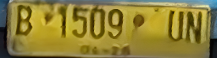

99
-179.35243159947615 



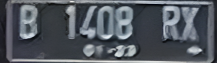

100


In [21]:
for dian in range (1,101):
  image = cv2.imread('/content/DataTest/DataTest'+str(dian)+'_out.png')
  # Melakukan proses contrast streching pada gambar
  image = contrast_stretching(image)
  # Melakukan resize image
  resized_image = resize_image(image)
  # Edge detection with canny
  edges = detect_edges(resized_image)
  # Detect horizontal edge from image
  lines = detect_lines(edges, threshold1=25, threshold2=10, min_line_length=15, max_line_gap=10)
  # Make a copy from reized image
  rgb_image = resized_image.copy()
  # Collect slopes from horizontal edge and add line to the image
  result = rgb_image.copy()
  green_slopes = []
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line[0]
      if abs(y2 - y1) <= abs(x2 - x1):
        cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
        slope = (y2 - y1) / (x2 - x1)
        green_slopes.append(slope)
  # Make distribution of slope horizontal edge
  slope_horizontal = average_middle_value(green_slopes)
  if green_slopes:
    # Calculate the rotation angle based on the average slope
    angle = np.degrees(np.arctan(slope_horizontal))

    # Create a rotation transformation matrix
    center = (resized_image.shape[1] // 2, resized_image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image
    resized_image = cv2.warpAffine(resized_image, M, (resized_image.shape[1], resized_image.shape[0]))
  # Rotate image
  rotated_image = rotated_90(resized_image)
  # Convert the image back to a NumPy array
  rotated_image = np.array(rotated_image)

  # Edge detection with canny
  new_edges = detect_edges(rotated_image)
  # Detect vertical edge from image
  new_lines = detect_lines(new_edges, threshold1=25, threshold2=15, min_line_length=15, max_line_gap=25)
  # Make a copy from reized image
  rgb_image = rotated_image.copy()

  # Collect slopes from horizontal edge and add line to the image
  result = rgb_image.copy()
  red_slopes = []
  if lines is not None:
    for line in new_lines:
      x1, y1, x2, y2 = line[0]
      if abs(y2 - y1) < abs(x2 - x1):
        cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)
        slope = (y2 - y1) / (x2 - x1)
        red_slopes.append(slope)
  # Visualize distribution of slope vertical edge
  slope_vertical = average_middle_value(red_slopes, bins = 20)
  # Make a copy from reized image
  rgb_image = rotated_image.copy()

  # Add black border to the image
  image_with_border = add_black_border(rgb_image, border_size = rgb_image.shape[1])
  if red_slopes:
    # Make sure zero divisor doesn't happen
    if slope_vertical == 0:
        slope_vertical = 0.0001

    # Calculate real slope
    real_slope = -1/slope_vertical

    # Calculate the slope angle in radians
    angle = math.degrees(math.atan(real_slope))
    real_angle = -(90 - angle)
    print(real_angle,'\n')

    # Transform the image
    transformed_image = transform_image(image_with_border, angle = real_angle)

    # Rotate image back to normal
    for i in range(3):
        transformed_image = rotated_90(transformed_image)
  if red_slopes:
    # Convert the image to grayscale
    gray_transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)

    # Calculate the percentage of black pixels
    total_pixels = gray_transformed_image.shape[0] * gray_transformed_image.shape[1]
    black_pixels = np.count_nonzero(gray_transformed_image == 0)
    percentage_black = (black_pixels / total_pixels) * 100
  if red_slopes and percentage_black < 90:
    # Crop the border on image
    resized_image = crop_black(transformed_image)

    # Convert the cropped image to a NumPy array
    resized_image = np.array(resized_image)
  # Get the original height and width of the image
  height, width = resized_image.shape[:2]

  # Define the desired width
  target_width = 300

  # Calculate the width ratio
  ratio = target_width / float(width)

  # Calculate the new height while maintaining the original aspect ratio
  target_height = int(height * ratio)

  # Resize the image using bicubic interpolation
  resized_image = cv2.resize(resized_image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)
  # Convert the resized image (numpy array) to PIL Image format
  image = Image.fromarray(resized_image)
  # Load the pre-trained YOLOS feature extractor and model for license plate detection
  feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
  model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')

  # Prepare the input tensors for the model inference
  inputs = feature_extractor(images=image, return_tensors="pt")

  # Perform inference using the model
  outputs = model(**inputs)
  # model predicts bounding boxes and corresponding face mask detection classes
  logits = outputs.logits
  bboxes = outputs.pred_boxes
  # convert outputs (bounding boxes and class logits) to COCO API
  target_sizes = torch.tensor([image.size[::-1]])
  results = feature_extractor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
  # copy image
  image_cv = np.array(image)
  image = image_cv.copy()
  # Iterate through the detected license plates
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    # Draw bounding box on the image
    cv2.rectangle(image_cv, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    # Add label and confidence score
    label_text = f'{model.config.id2label[label.item()]}: {round(score.item(), 3)}'
  # Extract the confidence scores from the results
  confidence = results['scores'].tolist()
  # Check if the maximum confidence score is greater than 90 and there is at least one detection
  if len(confidence) > 0:
    if max(confidence) > 0.9:
      # Crop the image based on bounding boxes
      cropped_images = []
      for box in results["boxes"]:
        box = [int(i) for i in box.tolist()]
        cropped_image = image[box[1]:box[3], box[0]:box[2]]
        cropped_images.append(cropped_image)

      # Convert the cropped image into an array
      resized_image = np.array(cropped_image)
  cv2_imshow(resized_image)
  # Save the cropped image using cv2.imwrite
  print(dian)
  cv2.imwrite('/content/Rotasi/Dataset_rotasi'+str(dian)+'.png', resized_image)


In [ ]:
import warnings

# Your code here

# Suppress specific warning
warnings.filterwarnings("ignore", message="Could not find image processor class*")
warnings.filterwarnings("ignore", message="Some weights of VisionEncoderDecoderModel*")

# Rest of your code

In [34]:
import pandas as pd
kunjaw = pd.read_csv('/content/KunJaw.csv')
kunjaw = kunjaw['Vehicleregistrationplatebymodel']

In [75]:
kunjaw

0      AD7034OE
1       A9388EX
2         B16TB
3      B1661TKZ
4     AD3772ABE
        ...    
95      B1285UL
96     AB8644PK
97     AG9718EG
98      B1509UN
99      B1408RX
Name: Vehicleregistrationplatebymodel, Length: 100, dtype: object

In [30]:
import cv2
import torch
from torchvision.models import detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [73]:
for safrizal in range (1,31):
  #processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
  #model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
  # Mendefinisikan URL gambar dan path tujuan
  #image_path = '/content/drive/MyDrive/BDC_Penyisihan/Data Test for BDC 2023 - Penyisihan/DataTest1.png'
  # Membuka gambar yang telah diunduh
  #image = Image.open('/content/Rotasi/Dataset_rotasi'+str(safrizal)'.png').convert("RGB")
  image = cv2.imread('/content/Rotasi/Dataset_rotasi'+str(safrizal)+'.png')
  pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  # Menghilangkan spasi dari output
  generated_text = generated_text.replace(" ", "")
  # Menerapkan filter menggunakan ekspresi reguler
  generated_text = re.sub(r'[^a-zA-Z0-9]', '', generated_text)
  if generated_text[0] =="8":
    generated_text = "B"+generated_text[1:]
  elif generated_text[0] =="6":
    generated_text = "B"+generated_text[1:]
  elif generated_text[0] =="4":
    generated_text = "A"+generated_text[1:]
  elif generated_text[-1:] =="6":
    generated_text = generated_text[:-1] +"O"
  elif generated_text[-2:-1] =="B":
    generated_text = generated_text[:-2] +"O"+generated_text[-1:]
  if 'T' in generated_text[:-3]:
    generated_text = generated_text.replace('T', '7', 1)
  if 'Z' in generated_text[:-3]:
    generated_text = generated_text.replace('Z', '2', 1)
  # Mengganti '0' dengan 'O' jika '0' terdeteksi pada dua karakter terakhir
  #if generated_text[-2:-1] == '0' or generated_text[-1:] == '0':
    #generated_text = generated_text[:-2] + 'O' + generated_text[-1]
  #if generated_text[-2:-1] == '8' or generated_text[-1:] == '8':
    #generated_text = generated_text[:-2] + 'O' + generated_text[-1]
  #if generated_text[0:1] == '8':
    #generated_text = "B" + generated_text[1:]
  #elif generated_text[1:2] == "8" :
    #generated_text = generated_text[0:1] + "B" + generated_text[2:]
  #if generated_text[-3:-2] =='1':
    #generated_text = generated_text[:4] +"T" +generated_text[6:]
  # Memotong output menjadi 9 karakter
  generated_text = generated_text[:9]
  # Menghitung keakuratan prediksi
  index = safrizal-1
  kunjawaban = kunjaw[index]
  # Menambahkan karakter tambahan jika panjang teks yang dihasilkan kurang dari kunjawaban
  if len(generated_text) < len(kunjawaban):
    generated_text += 'X' * (len(kunjawaban) - len(generated_text))

    # Menghitung keakuratan prediksi
  num_correct = sum(generated_text[i] == kunjawaban[i] for i in range(len(kunjawaban)))
  accuracy = num_correct / len(kunjawaban)

  print(generated_text, "|", kunjawaban, "|", "[", index + 1, "]", "|", num_correct, "/", len(kunjawaban))


AD7034OE | AD7034OE | [ 1 ] | 8 / 8
A9388EX | A9388EX | [ 2 ] | 7 / 7
B16TB | B16TB | [ 3 ] | 5 / 5
B1661TKZ | B1661TKZ | [ 4 ] | 8 / 8
AD3772ABE | AD3772ABE | [ 5 ] | 9 / 9
B27AVXX | B1271UV | [ 6 ] | 1 / 7
B1064TFR | B1064TFR | [ 7 ] | 8 / 8
B1395TJW | B1395TJM | [ 8 ] | 7 / 8
B1270RFD | B1270RFD | [ 9 ] | 8 / 8
B1736BYH | B1736BYH | [ 10 ] | 8 / 8
B162YBIE | B1627BIE | [ 11 ] | 7 / 8
B1628WZM | B1678WZM | [ 12 ] | 7 / 8
AD9313SS | AD9313SS | [ 13 ] | 8 / 8
B1036WUL | B1036UL | [ 14 ] | 5 / 7
B1801TZS | B1801TZS | [ 15 ] | 8 / 8
B1474TJS | B1474TJS | [ 16 ] | 8 / 8
B1939PU | B1939PU | [ 17 ] | 7 / 7
B1260TZT | B1260TZT | [ 18 ] | 8 / 8
B1376TJO | B1376TJO | [ 19 ] | 8 / 8
BY00 | B1QO | [ 20 ] | 1 / 4
A98328XX | AB6328IZ | [ 21 ] | 4 / 8
B1236PZN | B1236PZM | [ 22 ] | 7 / 8
AB86447PK | AB8644PK | [ 23 ] | 6 / 8
B1JKT | B1JKT | [ 24 ] | 5 / 5
AA70840D | AA70840D | [ 25 ] | 8 / 8
B1131EKG | B1131EKG | [ 26 ] | 8 / 8
B1037JN | B1037UN | [ 27 ] | 6 / 7
B1036JUL | B1036UL | [ 28 ] | 5 / 7


In [57]:
generated_text[:-2]

'B1736B'

Catatan:
- Citra Nomor 6 perlu di prosess lagi
- Citra Nomor 20 perlu di prosess lagi

In [38]:
generated_text[0]

'8'

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 21.3 MB/s eta 0:00:00


In [ ]:
import easyocr
import cv2
import re

# Define the languages for text recognition
languages = ['en']  # Add more languages if needed

# Initialize the EasyOCR reader with the desired languages
reader = easyocr.Reader(languages)

for safrizal in range(1, 101):
    # Load and preprocess the image
    image = cv2.imread('/content/Rotasi/Dataset_rotasi' + str(safrizal) + '.png')
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Perform text recognition
    results = reader.readtext(gray_image)

    # Process the OCR results
    generated_text = results[0][1]  # Assuming there is only one text detection
    # Remove spaces from the output
    generated_text = generated_text.replace(" ", "")
    # Apply regular expression filter
    generated_text = re.sub(r'[^a-zA-Z0-9]', '', generated_text)
    # Replace '0' with 'O' if '0' is detected in the last two characters
    if generated_text[-2:-1] == '0' or generated_text[-1:] == '0':
        generated_text = generated_text[:-2] + 'O' + generated_text[-1]
    if generated_text[-2:-1] == '8' or generated_text[-1:] == '8':
        generated_text = generated_text[:-2] + 'O' + generated_text[-1]
    if generated_text[0:1] == '8':
        generated_text = "B" + generated_text[1:]
    elif generated_text[1:2] == "8":
        generated_text = generated_text[0:1] + "B" + generated_text[2:]
    if generated_text[-3:-2] == '1':
        generated_text = generated_text[:4] + "T" + generated_text[6:]
    # Cut the output to 9 characters
    generated_text = generated_text[:9]

    index = safrizal - 1
    print(generated_text, kunjaw[index], "[", index + 1, "]")


AD703LBE AD7034OE [ 1 ]
33O8 A9388EX [ 2 ]
B B16TB [ 3 ]
B166TKZ B1661TKZ [ 4 ]
ad3772ABE AD3772ABE [ 5 ]


IndexError: ignored

In [ ]:
!pip install pytesseract

In [ ]:
import cv2
import pytesseract
import re

# Set the path to the Tesseract OCR executable
pytesseract.pytesseract.tesseract_cmd = r'<path_to_tesseract_executable>'

for safrizal in range(1, 101):
    # Load and preprocess the image
    image = cv2.imread('/content/Rotasi/Dataset_rotasi' + str(safrizal) + '.png')
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform OCR using Tesseract
    generated_text = pytesseract.image_to_string(gray_image)

    # Process the OCR output
    generated_text = generated_text.replace(" ", "")
    generated_text = re.sub(r'[^a-zA-Z0-9]', '', generated_text)
    # Replace '0' with 'O' if '0' is detected in the last two characters
    if generated_text[-2:-1] == '0' or generated_text[-1:] == '0':
        generated_text = generated_text[:-2] + 'O' + generated_text[-1]
    if generated_text[-2:-1] == '8' or generated_text[-1:] == '8':
        generated_text = generated_text[:-2] + 'O' + generated_text[-1]
    if generated_text[0:1] == '8':
        generated_text = "B" + generated_text[1:]
    elif generated_text[1:2] == "8":
        generated_text = generated_text[0:1] + "B" + generated_text[2:]
    if generated_text[-3:-2] == '1':
        generated_text = generated_text[:4] + "T" + generated_text[6:]
    # Cut the output to 9 characters
    generated_text = generated_text[:9]

    index = safrizal - 1
    print(generated_text, kunjaw[index], "[", index + 1, "]")


TesseractNotFoundError: ignored

In [ ]:
#resized_image = image

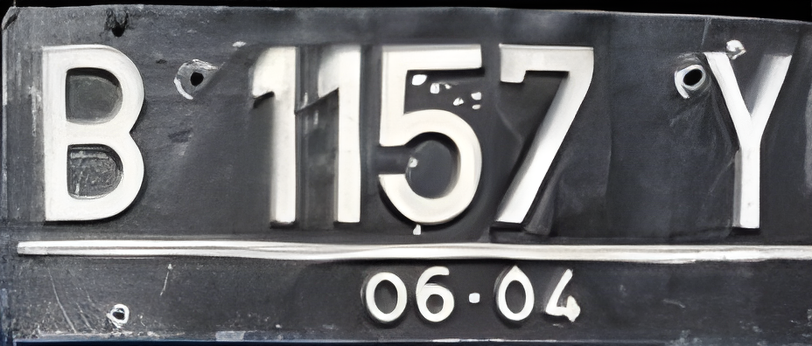

In [ ]:
# Show sample image
cv2_imshow(image)

# **Preprocessing Dataset**

## **Basic Preprocessing**

### **Contrast Streching Image**

In [ ]:
# Melakukan proses contrast streching pada gambar
image = contrast_stretching(image)

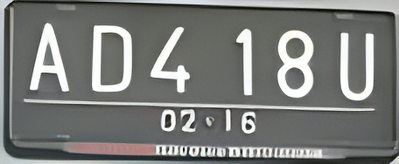

In [ ]:
# Menampilkan gambar yang sudah dilakukan contrast streching
cv2_imshow(image)

### **Resize Image**

In [ ]:
# Melakukan resize image
resized_image = resize_image(image)

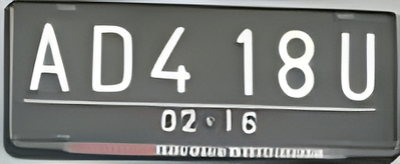

In [ ]:
# Menampilkan gambar yang sudah diresize
cv2_imshow(resized_image)

## **Rotate and Skewness Preprocessing**

### **Horizontal Edge Detection**

In [ ]:
# Edge detection with canny
edges = detect_edges(resized_image)

In [ ]:
# Detect horizontal edge from image
lines = detect_lines(edges, threshold1=25, threshold2=10, min_line_length=15, max_line_gap=10)

In [ ]:
# Make a copy from reized image
rgb_image = resized_image.copy()

In [ ]:
# Collect slopes from horizontal edge and add line to the image
result = rgb_image.copy()
green_slopes = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) <= abs(x2 - x1):
            cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
            slope = (y2 - y1) / (x2 - x1)
            green_slopes.append(slope)

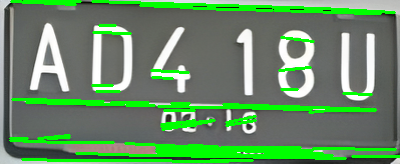

In [ ]:
# Show image with horizontal edge
cv2_imshow(result)

Average slope edge on highest bar: 0.0005387931034482596 



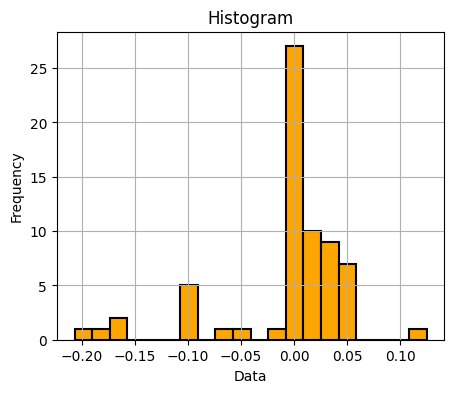

In [ ]:
# Make distribution of slope horizontal edge
slope_horizontal = average_middle_value(green_slopes)

# Print average slope edge on highest bar
print('Average slope edge on highest bar:', slope_horizontal,'\n')

# Visualize distribution
create_histogram(green_slopes)

In [ ]:
if green_slopes:
    # Calculate the rotation angle based on the average slope
    angle = np.degrees(np.arctan(slope_horizontal))

    # Create a rotation transformation matrix
    center = (resized_image.shape[1] // 2, resized_image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image
    resized_image = cv2.warpAffine(resized_image, M, (resized_image.shape[1], resized_image.shape[0]))

### **Rotated Image Based on Horizontal Slope**

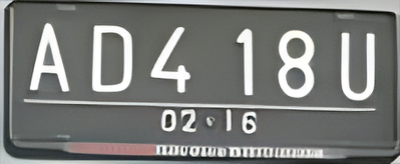

In [ ]:
# Show rotated image
cv2_imshow(resized_image)

### **Rotated Image 90 degree**

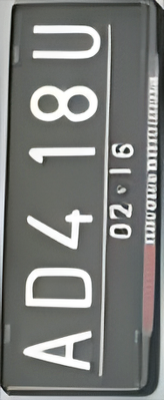

In [ ]:
# Rotate image
rotated_image = rotated_90(resized_image)

# Show rotated image
cv2_imshow(rotated_image)

### **Vertical Edge Detection**

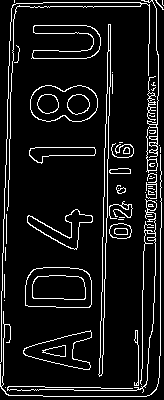

In [ ]:
# Convert the image back to a NumPy array
rotated_image = np.array(rotated_image)

# Edge detection with canny
new_edges = detect_edges(rotated_image)

# Show image's edge
cv2_imshow(new_edges)

In [ ]:
# Detect vertical edge from image
new_lines = detect_lines(new_edges, threshold1=25, threshold2=15, min_line_length=15, max_line_gap=25)

In [ ]:
# Make a copy from reized image
rgb_image = rotated_image.copy()

# Collect slopes from horizontal edge and add line to the image
result = rgb_image.copy()
red_slopes = []
if lines is not None:
    for line in new_lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < abs(x2 - x1):
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)
            slope = (y2 - y1) / (x2 - x1)
            red_slopes.append(slope)

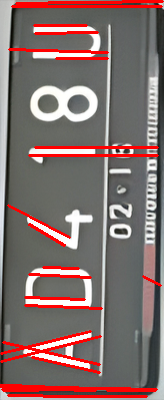

In [ ]:
# Show image with vertical edge
cv2_imshow(result)

Average slope edge on highest bar : -0.018080808080808114 



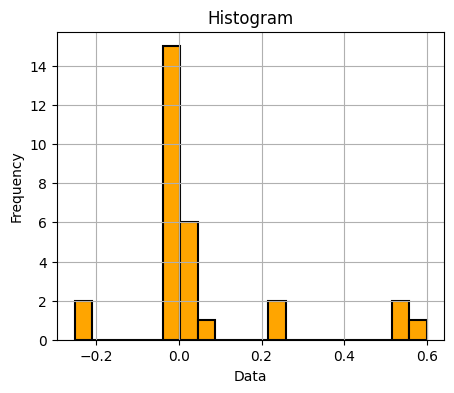

In [ ]:
# Visualize distribution of slope vertical edge
slope_vertical = average_middle_value(red_slopes, bins = 20)

# Print average slope edge on highest bar
print('Average slope edge on highest bar :', slope_vertical,'\n')

# Visualize distribution
create_histogram(red_slopes, bins = 20)

### **Add Border to Image**

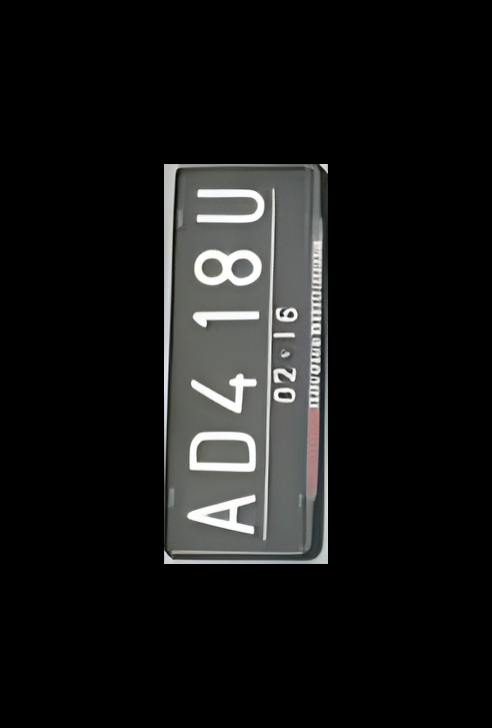

In [ ]:
# Make a copy from reized image
rgb_image = rotated_image.copy()

# Add black border to the image
image_with_border = add_black_border(rgb_image, border_size = rgb_image.shape[1])

# Display the image with the added border
cv2_imshow(image_with_border)

-1.0358411255068205 



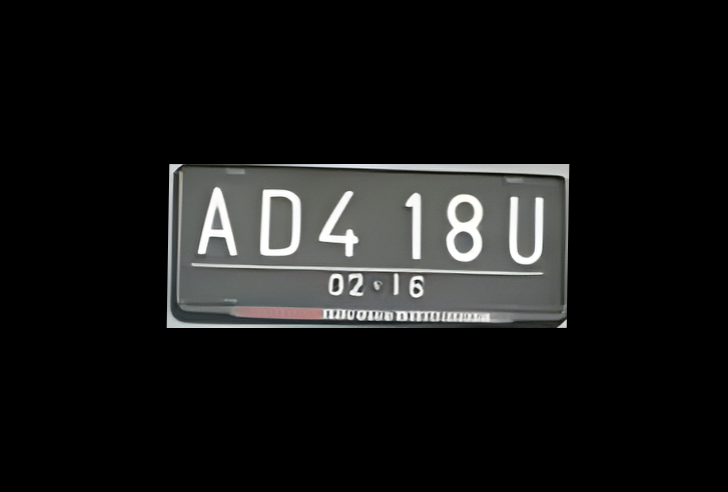

In [ ]:
if red_slopes:
    # Make sure zero divisor doesn't happen
    if slope_vertical == 0:
        slope_vertical = 0.0001

    # Calculate real slope
    real_slope = -1/slope_vertical

    # Calculate the slope angle in radians
    angle = math.degrees(math.atan(real_slope))
    real_angle = -(90 - angle)
    print(real_angle,'\n')

    # Transform the image
    transformed_image = transform_image(image_with_border, angle = real_angle)

    # Rotate image back to normal
    for i in range(3):
        transformed_image = rotated_90(transformed_image)

    # Show cropped image
    cv2_imshow(transformed_image)

In [ ]:
if red_slopes:
    # Convert the image to grayscale
    gray_transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)

    # Calculate the percentage of black pixels
    total_pixels = gray_transformed_image.shape[0] * gray_transformed_image.shape[1]
    black_pixels = np.count_nonzero(gray_transformed_image == 0)
    percentage_black = (black_pixels / total_pixels) * 100

    # Print percentage black space
    print(f"Percentage black space: {percentage_black:.2f}%")

Percentage black space: 81.64%


### **Rotated Image Based on Vertical Slope**

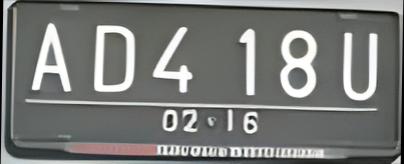

In [ ]:
if red_slopes and percentage_black < 90:
    # Crop the border on image
    resized_image = crop_black(transformed_image)

    # Convert the cropped image to a NumPy array
    resized_image = np.array(resized_image)

# Show cropped image
cv2_imshow(resized_image)

## **Bounding Box Preprocessing**

### **Resize Image**

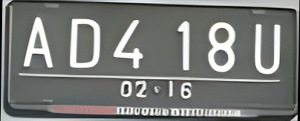

In [ ]:
# Get the original height and width of the image
height, width = resized_image.shape[:2]

# Define the desired width
target_width = 300

# Calculate the width ratio
ratio = target_width / float(width)

# Calculate the new height while maintaining the original aspect ratio
target_height = int(height * ratio)

# Resize the image using bicubic interpolation
resized_image = cv2.resize(resized_image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

# Display the original and resized images
cv2_imshow(resized_image)

### **Bounding Box Cropping**

In [ ]:
# Convert the resized image (numpy array) to PIL Image format
image = Image.fromarray(resized_image)

In [ ]:
# Load the pre-trained YOLOS feature extractor and model for license plate detection
feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')

# Prepare the input tensors for the model inference
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference using the model
outputs = model(**inputs)

/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [ ]:
# model predicts bounding boxes and corresponding face mask detection classes
logits = outputs.logits
bboxes = outputs.pred_boxes

In [ ]:
# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = feature_extractor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

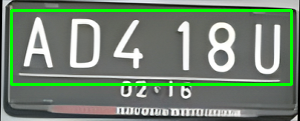

In [ ]:
# copy image
image_cv = np.array(image)
image = image_cv.copy()

# Iterate through the detected license plates
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    # Draw bounding box on the image
    cv2.rectangle(image_cv, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    # Add label and confidence score
    label_text = f'{model.config.id2label[label.item()]}: {round(score.item(), 3)}'

# Display the image with bounding boxes
cv2_imshow(image_cv)

In [ ]:
# Extract the confidence scores from the results
confidence = results['scores'].tolist()
print("Confidence score :", confidence)

Confidence score : [0.9908418655395508]


In [ ]:

# Check if the maximum confidence score is greater than 90 and there is at least one detection
if len(confidence) > 0:
    if max(confidence) > 0.9:
        # Crop the image based on bounding boxes
        cropped_images = []
        for box in results["boxes"]:
            box = [int(i) for i in box.tolist()]
            cropped_image = image[box[1]:box[3], box[0]:box[2]]
            cropped_images.append(cropped_image)

        # Convert the cropped image into an array
        resized_image = np.array(cropped_image)

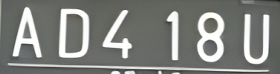

In [ ]:
cv2_imshow(resized_image)

# **Saving Preprocessed Image**

In [ ]:
# Save the cropped image using cv2.imwrite
cv2.imwrite('/content/file5.png', resized_image)

True

# **OCR Process**

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import re
from PIL import Image
# Mendefinisikan URL gambar dan path tujuan
#image_path = '/content/drive/MyDrive/BDC_Penyisihan/Data Test for BDC 2023 - Penyisihan/DataTest1.png'
# Membuka gambar yang telah diunduh
#image = Image.open(image_path).convert("RGB")
image = resized_image
pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# Menghilangkan spasi dari output
generated_text = generated_text.replace(" ", "")
# Menerapkan filter menggunakan ekspresi reguler
generated_text = re.sub(r'[^a-zA-Z0-9]', '', generated_text)
# Mengganti '0' dengan 'O' jika '0' terdeteksi pada dua karakter terakhir
if generated_text[-2:-1] == '0' or generated_text[-1:] == '0':
    generated_text = generated_text[:-2] + 'O' + generated_text[-1]
if generated_text[-2:-1] == '8' or generated_text[-1:] == '8':
    generated_text = generated_text[:-2] + 'O' + generated_text[-1]
if generated_text[0:1] == '8':
  generated_text = "B" + generated_text[1:]
elif generated_text[1:2] == "8" :
  generated_text = generated_text[0:1] + "B" + generated_text[2:]
if generated_text[-3:-2] =='1':
  generated_text = generated_text[:4] +"T" +generated_text[6:]
# Memotong output menjadi 9 karakter
generated_text = generated_text[:9]

# **Print Prediction**

In [ ]:
import pandas as pd
kunjaw = pd.read_csv('/content/KunJaw.csv')
kunjaw = kunjaw['Vehicleregistrationplatebymodel']

In [ ]:
index = 61
print(generated_text, kunjaw[index])
print(len(kunjaw[index]))

AD41T AD418U
6


50 -> 100%
51